# Appendix B

This jupyter notebook contains analysis of counts of ED Breaches and Delayed Transfers Of Care at English Trusts August 2010-March 2017. 

# import dependancies

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('NHSE_data.csv')
df.shape

(80, 10)

In [3]:
df.head()

,year,month,total_attendances,total_attendances_t1,total_breaches,95%_targ,total_admissions,dtoc_a,dtoc_na,total_dtocs
0,2010-11,August,1719197.000,1138652.000,33184.00000,0.980698,425702.0000,2559,2381,4940
1,2010-11,September,1715117.000,1150728.000,41151.00000,0.976007,424900.0000,2647,2357,5004
2,2010-11,October,1753934.000,1163143.000,47414.00000,0.972967,436215.0000,2513,2075,4588
3,2010-11,November,1604591.000,1111294.571,46436.42857,0.971060,429099.0000,2352,2057,4409
4,2010-11,December,1647823.857,1159203.857,89917.28571,0.945433,452728.7143,1995,1866,3861


make flag for data used in previous analysis

In [4]:
df['flag_previous'] = 0

df.loc[0:68,'flag_previous'] = 1

In [5]:
df = df[df.flag_previous == 1] # remove most recent data to reproduce previosu analysis

In [6]:
df = df[['total_breaches','total_dtocs']]

# Data briefing reproduction

A reproduction of the analysis in BMJ data briefing.

In [7]:
from scipy import stats

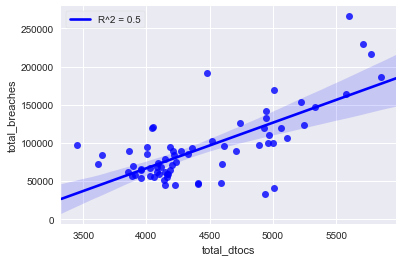

In [63]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs'],df['total_breaches'])

# use line_kws to set line label for legend
ax = sns.regplot(x="total_dtocs", y="total_breaches", data=df, marker='o',color='b', 
 line_kws={'label': "R^2 = {0:.1f}".format(r_value**2)})

ax.legend(frameon=True)


In [9]:
df[['total_dtocs','total_breaches']].corr('spearman')

,total_dtocs,total_breaches
total_dtocs,1.000000,0.541635
total_breaches,0.541635,1.000000


### distribution of data

Data appears to not be noramlly distributed. Hence, we use spearman rank correlation coefficient.

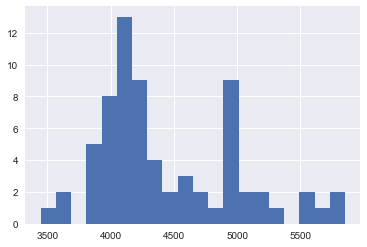

In [10]:
df.total_dtocs.hist(bins=20);

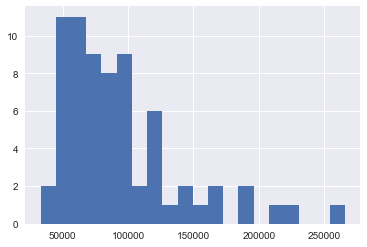

In [11]:
df.total_breaches.hist(bins=20);

# autocorrelation calculations

In [12]:
def auto_corr(df,column,lags,how='spearman'):
    
    #### get lagged cols
    dftemp = pd.DataFrame(df[column])
    result = dftemp.copy()
    #result = pd.DataFrame()
    
    #### create new columns with shifted vars
    for i in np.arange(1,lags):

        dftemp2 = dftemp.shift(i).copy() # get new series with shoifted data
        dftemp2.rename(columns={column:str(i)},inplace=True) #rename col to lag no
        result  = result.merge(dftemp2, how='outer',left_index=True,right_index=True) # merge with running results df
        
    # calc correlation coef nad get table of results
    result_corr = result.corr(how)[column].reset_index(drop=True)
    return(result_corr)

In [97]:
def compute_crosscorr_mult_inputs(df,xvars,lags,title='', how='spearman'):
    ''' create df with lagged correlation scores (auto-correlation) for multiple variables'''
    
    corr_scores = pd.DataFrame()
    for i in xvars:
        corrs = auto_corr(df,i,lags,how)
        corr_scores[i] = corrs
    ax = plt.subplot()
    corr_scores.plot(ax=ax)
    ax.set_ylabel('correlation coef')
    ax.set_xlabel('lag (months)')
    ax.set_ylim([-0.4,1])
    ax.plot((0,corr_scores.shape[0]),(0,0),'k--') # plot 0 line
    ax.set_title(title)
    return(corr_scores)

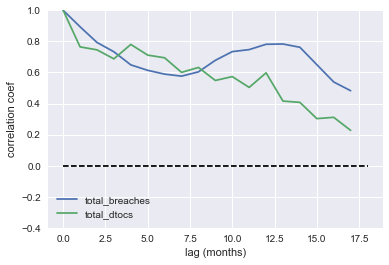

In [98]:
corr_scores = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs'],18)

Using dickey-fuller test to ascertain stationarity:

In [20]:
from statsmodels.tsa.stattools import adfuller

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [22]:
check_stationarity(df['total_breaches'])

ADF Statistic: -1.555714
p-value: 0.505793
	5%: -2.905
	10%: -2.590
	1%: -3.530


In [23]:
check_stationarity(df['total_dtocs'])

ADF Statistic: 1.641969
p-value: 0.997978
	5%: -2.914
	10%: -2.595
	1%: -3.551


There is high auto-correlation in both the numbers of breaches & numbers of dtocs. This is due to each timeseries having  increasing growth over time, i.e. they are non-stationary. This is very clear upon plotting the time-series below.

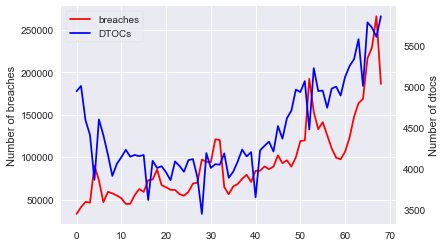

In [72]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

### detrend using fitted polynomial

We can detrend the time-series in a crude way by fitting polynomials.

In [73]:
import scipy

#### fit DTOCs with polynomial

In [74]:
def func_dtoc(x, a, b, c):
    return (a * x) + (b * x**2) + c

In [75]:
def detrend_using_func(dta,column,func,ylabel,color='b'):
    
    #### fit func
    xdata = dta.index
    ydata = dta[column]
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    
    #### plot fig
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    df[column].plot(color=color, ax=ax, label=ylabel)#, width=width)#, position=0)
    plt.plot(xdata, func(xdata, *popt), color+ '--',
              label='fit:a=%5.3f,  b=%5.3f, c=%5.3f' % tuple(popt)) #

    ax.set_ylabel(ylabel)
    ax.legend(frameon=True)
    plt.show()
    
    #### make new column with detrended data
    dta.loc[dta.index,column+'_detrend'] = dta[column] - func(dta[column].index,popt[0],popt[1],popt[2])
    
    return dta

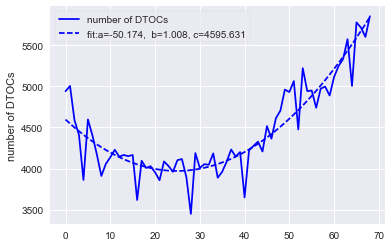

In [76]:
df = detrend_using_func(df,'total_dtocs',func_dtoc,'number of DTOCs')

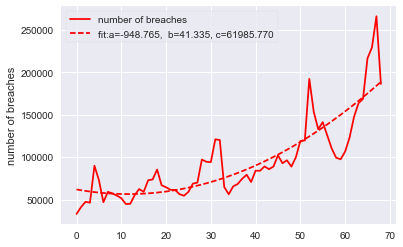

In [77]:
df = detrend_using_func(df,'total_breaches',func_dtoc,'number of breaches','r')

Plotting the time-series (below) we see there is now no increasing trend over time.

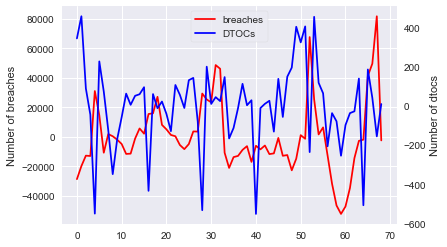

In [82]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches_detrend.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs_detrend.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax2.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

# Analysis on detrended data

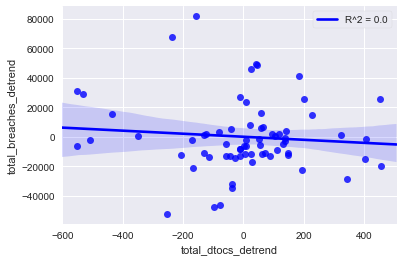

In [84]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs_detrend'],df['total_breaches_detrend'])

# use line_kws to set line label for legend
ax = sns.regplot(x="total_dtocs_detrend", y="total_breaches_detrend", data=df, marker='o',color='b', 
 line_kws={'label':"R^2 = {0:.1f}".format(r_value**2)})

ax.legend(frameon=True)


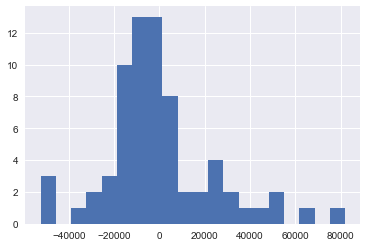

In [95]:
df.total_breaches_detrend.hist(bins=20)

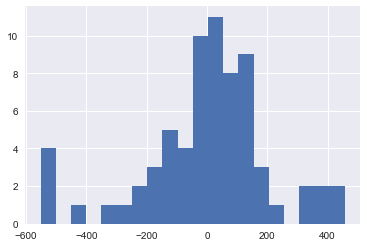

In [96]:
df.total_dtocs_detrend.hist(bins=20)

In [89]:
df.corr('pearson')

,total_breaches,total_dtocs,total_dtocs_detrend,total_breaches_detrend
total_breaches,1.000000,0.710060,-0.047311,0.516786
total_dtocs,0.710060,1.000000,0.385230,-0.035268
total_dtocs_detrend,-0.047311,0.385230,1.000000,-0.091549
total_breaches_detrend,0.516786,-0.035268,-0.091549,1.000000


In [88]:
df.corr('spearman')

,total_breaches,total_dtocs,total_dtocs_detrend,total_breaches_detrend
total_breaches,1.000000,0.541635,-0.028754,0.268542
total_dtocs,0.541635,1.000000,0.383719,-0.260532
total_dtocs_detrend,-0.028754,0.383719,1.000000,0.017830
total_breaches_detrend,0.268542,-0.260532,0.017830,1.000000


In [140]:
df.corr('spearman')[['total_breaches','total_breaches_diff','total_breaches_detrend']].ix[['total_dtocs','total_dtocs_diff','total_dtocs_detrend']]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


,total_breaches,total_breaches_diff,total_breaches_detrend
total_dtocs,0.541635,0.024813,-0.151704
total_dtocs_diff,0.130306,-0.139907,-0.175638
total_dtocs_detrend,-0.028754,-0.128908,0.007088


# autocorrelation

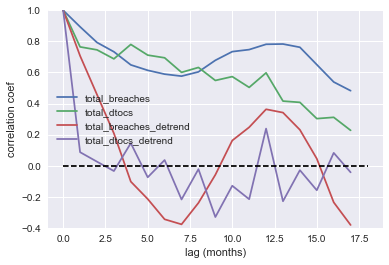

In [99]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches','total_dtocs','total_breaches_detrend','total_dtocs_detrend'],18)

!# check that these are same results as ACF in statsmodles?

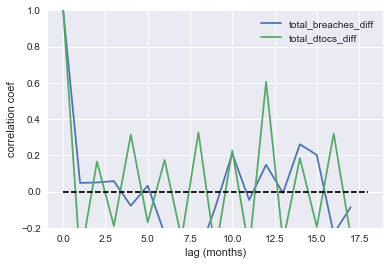

In [129]:
corr_scores_diff = compute_crosscorr_mult_inputs(df,['total_breaches_diff','total_dtocs_diff'],18)